In [1]:
%cd ..

/home/juanhevia/IDIL


In [2]:
from collections import defaultdict
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt 
import os 
from idil_algs.IDIL.agent.mental_iql import MentalIQL
from munch import Munch
import yaml
import idil_gym
from idil_algs.baselines.IQLearn.dataset.expert_dataset import ExpertDataset
from idil_algs.baselines.IQLearn.utils.utils import make_env
import gym


RESULTS_PATH="./idil_train/result/"


def load_expert_data_w_labels(demo_path, num_trajs, n_labeled, seed):
    expert_dataset = ExpertDataset(demo_path, num_trajs, 1, seed + 42)
    print(f'--> Expert memory size: {len(expert_dataset)}')

    cnt_label = 0
    traj_labels = []
    for i_e in range(num_trajs):
        if "latents" in expert_dataset.trajectories:
            expert_latents = expert_dataset.trajectories["latents"][i_e]
        else:
            expert_latents = None

        if i_e < n_labeled:
            traj_labels.append(expert_latents)
            cnt_label += 1
        else:
            traj_labels.append(None)

    print(f"num_labeled: {cnt_label} / {num_trajs}, num_samples: ",
        len(expert_dataset))
    return expert_dataset, traj_labels, cnt_label

def compute_sequence_accuracy(pred_latents, true_latents):
    pred_latents = np.array(pred_latents)
    true_latents = np.array(true_latents)
    return np.sum(pred_latents == true_latents) / len(true_latents)

# Agent loading

def get_run_path(env_name: str, run_id: str):
    """
    Get the path where we store 'model' and 'log' data for a given run
    """
    # read one dir below, as there is always a date directory
    _path = os.path.join(RESULTS_PATH, env_name, 'idil', run_id)
    _date_folder = os.listdir(_path)[0]
    return os.path.join(_path, _date_folder)

def get_run_config(run_path:str):
    """
    Parse run YAML configuration and return as Munch dictioanry object
    """

    with open(os.path.join(run_path, 'log', 'config.yaml') , "r") as f:
        run_conf = yaml.load(f, Loader=yaml.FullLoader)
        run_conf = Munch(run_conf)
    return run_conf

def get_agent(run_path: str, run_conf: Munch):
    """
    Load the agent from the run path
    """
    # load env
    env = make_env(run_conf.env_name)

    _obs_space_dim = env.observation_space.n if isinstance(env.observation_space, gym.spaces.Discrete) else env.observation_space.shape[0]
    _act_space_dim = env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) else env.action_space.shape[0]    

    miql_agent = MentalIQL(config=run_conf,
                           obs_dim=_obs_space_dim,
                           action_dim=_act_space_dim,
                           lat_dim=run_conf.dim_c, # obs dim and action dim are hardcoded for now, they belogn to CleanupSingle
                           discrete_obs=isinstance(env.observation_space, gym.spaces.Discrete),
                           discrete_act=isinstance(env.action_space, gym.spaces.Discrete))

    prefix = os.listdir(os.path.join(run_path, 'model'))[0].replace('_pi', '').replace('_tx', '').strip()

    miql_agent.load(os.path.join(run_path, 'model', prefix))
    return miql_agent

# Actions accuracy

In [3]:
def backtest_action_trajectory(expert_dataset, agent):
    """
    Given a precomputed set of latents and states,
    run the agent to sample an action and see how the actions differ
    """

    agent_action_trajs = []

    for traj_idx in range(len(expert_dataset.trajectories["states"])):
        traj_states = expert_dataset.trajectories["states"][traj_idx]
        traj_latents = expert_dataset.trajectories["latents"][traj_idx]

        _action_traj = []
        for _state, _lat in zip(traj_states, traj_latents):
            _action = agent.choose_policy_action(_state, _lat)
            _action_traj.append(_action)

        agent_action_trajs.append(_action_traj)

    return agent_action_trajs

def compute_action_accuracy(expert_dataset, agent):
    """
    Compute the action accuracy between expert and agent
    """

    agent_action_trajs = backtest_action_trajectory(expert_dataset, agent)

    accs = []
    for i in range(len(expert_dataset.trajectories["states"])):
        _test_acts_expert = np.array(expert_dataset.trajectories["actions"][i])
        _test_acts_agent =  np.array(agent_action_trajs[i])

        accs.append(np.sum(_test_acts_expert == _test_acts_agent) / len(_test_acts_expert))

    return accs

# Review `CleanupSingle`

In [4]:
expert_dataset, expert_traj_labels, _ = load_expert_data_w_labels("idil_train/experts/CleanupSingle-v0_100.pkl", 100, 100, 0)

--> Expert memory size: 4693
num_labeled: 100 / 100, num_samples:  4693


In [6]:
MODEL_IDS = [
    "es-0-01J2HQWGWCZA0NBZVPQANCGPNS", # k = 0
    "es-20-01J2J30NGSV69VCBP4VZ21NXNE", # k = 20%
    "es-60-01J2JK31NFMYFTGW3EAVBPRKRN", # k = 60%
    "es-100-01J2JXRH7C4T52V32DAEG4N19Y" # k = 100%
]

agents = {}

for mid in MODEL_IDS:
    _k = mid.split("-")[1]
    print(f"Working with k = {_k}")

    _run_path = get_run_path("CleanupSingle-v0", mid)
    _run_config = get_run_config(run_path=_run_path)

    # move all computation to cpu:
    _run_config.device = 'cpu'

    _agent = get_agent(_run_path, _run_config)

    agents[_k] = {
        'agent': _agent,
        'run_config': _run_config
    }

print(agents.keys())


Working with k = 0
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-0-01J2HQWGWCZA0NBZVPQANCGPNS/2024-07-11_15-31-21/model/iq_CleanupSingle-v0_n100_l50_best_tx
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-0-01J2HQWGWCZA0NBZVPQANCGPNS/2024-07-11_15-31-21/model/iq_CleanupSingle-v0_n100_l50_best_pi
Working with k = 20
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-20-01J2J30NGSV69VCBP4VZ21NXNE/2024-07-11_18-45-51/model/iq_CleanupSingle-v0_n100_l50_best_tx
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-20-01J2J30NGSV69VCBP4VZ21NXNE/2024-07-11_18-45-51/model/iq_CleanupSingle-v0_n100_l50_best_pi
Working with k = 60
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-60-01J2JK31NFMYFTGW3EAVBPRKRN/2024-07-11_23-26-46/model/iq_CleanupSingle-v0_n100_l50_best_tx
Loading models from ./idil_train/result/CleanupSingle-v0/idil/es-60-01J2JK31NFMYFTGW3EAVBPRKRN/2024-07-11_23-26-46/model/iq_CleanupSingle-v0_n100_l50_bes

In [7]:
k_vals = agents.keys()

In [8]:
from collections import defaultdict
from tqdm import tqdm

accs_by_k = defaultdict(list)

for traj_idx in tqdm(range(len(expert_dataset.trajectories["states"]))):
    _states = expert_dataset.trajectories["states"][traj_idx]
    _actions = expert_dataset.trajectories["actions"][traj_idx]

    _latents = expert_traj_labels[traj_idx]
    for k in k_vals:
        _agent = agents[k]['agent']
        _inferred_latents, _, _ = _agent.infer_mental_states(_states, _actions)

        _acc = compute_sequence_accuracy(_inferred_latents.squeeze(1), _latents)
        accs_by_k[k].append(_acc)


100%|██████████| 100/100 [00:01<00:00, 50.84it/s]


In [9]:
df_accs = pd.DataFrame(accs_by_k)

df_accs

,0,20,60,100
0,1.000000,0.723404,1.000000,0.702128
1,1.000000,1.000000,1.000000,0.895833
2,0.420000,1.000000,0.980000,0.920000
3,1.000000,1.000000,1.000000,1.000000
4,0.750000,0.977273,0.931818,1.000000
...,...,...,...,...
95,0.921569,1.000000,1.000000,0.980392
96,1.000000,1.000000,0.770833,1.000000
97,1.000000,1.000000,1.000000,1.000000
98,0.700000,1.000000,1.000000,1.000000


[Text(1, 0, '0%'), Text(2, 0, '20%'), Text(3, 0, '60%'), Text(4, 0, '100%')]

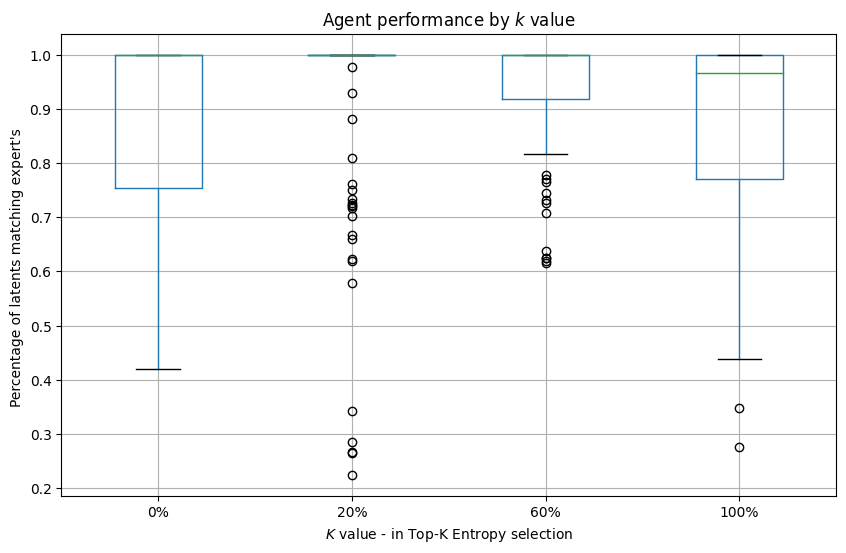

In [12]:
# plot a violing plot where the k value is at the horizontal axis and the accuracy is at the vertical axis
plt.figure(figsize=(10, 6))

df_accs.boxplot()
plt.ylabel(r"Percentage of latents matching expert's ")
plt.xlabel("$K$ value - in Top-K Entropy selection")
plt.title("Agent performance by $k$ value")

# format x-axis as percentage
plt.gca().set_xticklabels([f"{int(k)}%" for k in k_vals])
